In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

df = pd.read_csv(r'data/data_processed.csv')
df_cat = pd.read_csv(r'data/data_categorical.csv')

df_good = pd.concat([df_cat, df["MonthlyIncome"], df["BusinessTravel"], df["StockOptionLevel"], df["DistanceFromHome"]], axis=1)

# print(df_good)
# copy attrition and drop from dataframe
JAtt = df["Attrition"].values

df_good = df_good.drop(["Unnamed: 0"], axis=1)
# df_good = df_good.drop(['Attrition'], axis=1)
# print(df_good)

# splitting new df
df_train = df_good.iloc[:1200,:]
df_val = df_good.iloc[1200:,:]
# splitting Jatt into new sizes
JAtt_train = JAtt[:1200]
JAtt_val = JAtt[1200:]


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

# split data into training, validation and test
train, val, test = np.split(df_good.sample(frac=1), [int(0.8*len(df_good)), int(0.9*len(df_good))])

print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')


1176 training examples
147 validation examples
147 test examples


In [4]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  _df = dataframe.copy()
  target = _df.pop('Attrition')

  _df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(_df), target))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

ds_train = df_to_dataset(train, True, 5)

[(train_features, label_batch)] = ds_train.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of job JobSatisfaction:', train_features["JobSatisfaction"])
print('A batch of targets:', label_batch )


C:\Users\siman\AppData\Local\Temp\ipykernel_15960\3579807351.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  _df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


Every feature: ['Attrition', 'BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MaritalStatus', 'NumCompaniesWorked', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance', 'MonthlyIncome', 'DistanceFromHome']
A batch of job JobSatisfaction: tf.Tensor(
[[1]
 [4]
 [2]
 [4]
 [2]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int64)


In [7]:

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

monthly_rate_col = df["MonthlyIncome"]
layer = get_normalization_layer('MonthlyIncome', ds_train)
layer(monthly_rate_col)


<tf.Tensor: shape=(1, 1470), dtype=float32, numpy=
array([[ 0.83784705, -0.29404953, -0.28682104, ..., -0.7947288 ,
        -0.17626764, -0.7328614 ]], dtype=float32)>

In [10]:

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

# test on dep
test_dep_col = df['JobSatisfaction']
test_dep_layer = get_category_encoding_layer(name='JobSatisfaction',
                                              dataset=ds_train,
                                              dtype='int64')
print(test_dep_layer(test_dep_col))

# test on education
test_education_col = df['WorkLifeBalance']
test_dep_layer = get_category_encoding_layer(name='WorkLifeBalance',
                                              dataset=ds_train,
                                              dtype='int64')
print(test_dep_layer(test_education_col))


tf.Tensor([0. 1. 1. 1. 1.], shape=(5,), dtype=float32)
tf.Tensor([0. 1. 1. 1. 1.], shape=(5,), dtype=float32)


In [13]:
batch_size = 1176

train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# split categorical and continuous data
# # full data set
# header_continous = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'PercentSalaryHike', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
# header_categorical = ['Attrition', 'BusinessTravel', 'Department', 'Education','EducationField','EnvironmentSatisfaction','Gender','JobInvolvement','JobLevel','JobRole','JobSatisfaction','MaritalStatus','NumCompaniesWorked', 'OverTime','PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel','TrainingTimesLastYear', 'WorkLifeBalance']
# optimized data
# header_continous = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
header_continous = np.array(["MonthlyIncome", "BusinessTravel", "StockOptionLevel", "DistanceFromHome"])
# header_categorical = ['Attrition', 'BusinessTravel', 'Education','EnvironmentSatisfaction','JobInvolvement','JobLevel','JobSatisfaction','MaritalStatus','NumCompaniesWorked', 'OverTime','PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel','TrainingTimesLastYear', 'WorkLifeBalance']
header_categorical = np.array(['JobSatisfaction','EnvironmentSatisfaction','JobInvolvement','PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance'])


C:\Users\siman\AppData\Local\Temp\ipykernel_15960\3579807351.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  _df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
C:\Users\siman\AppData\Local\Temp\ipykernel_15960\3579807351.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  _df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
C:\Users\siman\AppData\Local\Temp\ipykernel_15960\3579807351.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  _df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [14]:
all_inputs = []
encoded_features = []
encoded_numerical = []
encoded_categorical = []
encoded_survey = []

use_continous = True

# Numerical features.
if use_continous:
  for header in header_continous:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)
    encoded_numerical.append(encoded_numeric_col)

In [15]:
for header in header_categorical:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='int64',
                                               max_tokens=None)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)
  encoded_categorical.append(encoded_categorical_col)

In [26]:
all_features = tf.keras.layers.concatenate(encoded_features)
# categorical_features = tf.keras.layers.concatenate(encoded_categorical)
# if use_continous:
#     numerical_features = tf.keras.layers.concatenate(encoded_numerical)

# if use_continous:
#     x1 = tf.keras.layers.Dense(15, activation="relu", kernel_initializer=tf.keras.initializers.Zeros())(numerical_features)
# # x1 = tf.keras.layers.Dropout(0.3)(x1)
# x2 = tf.keras.layers.Dense(15, activation="sigmoid")(categorical_features)
# # x2 = tf.keras.layers.Dropout(0.8)(x2)
# if use_continous:
#     x = tf.keras.layers.concatenate([x1, x2])
# else:
#     x=tf.keras.layers.Dense(10, activation="relu")(x2)
# # x = tf.keras.layers.Dense(10, activation="relu")(x)
# x = tf.keras.layers.Dense(7, activation="relu")(x)

x = tf.keras.layers.Dense(16)(all_features)
x = tf.keras.layers.Dense(8)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)


In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy', tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

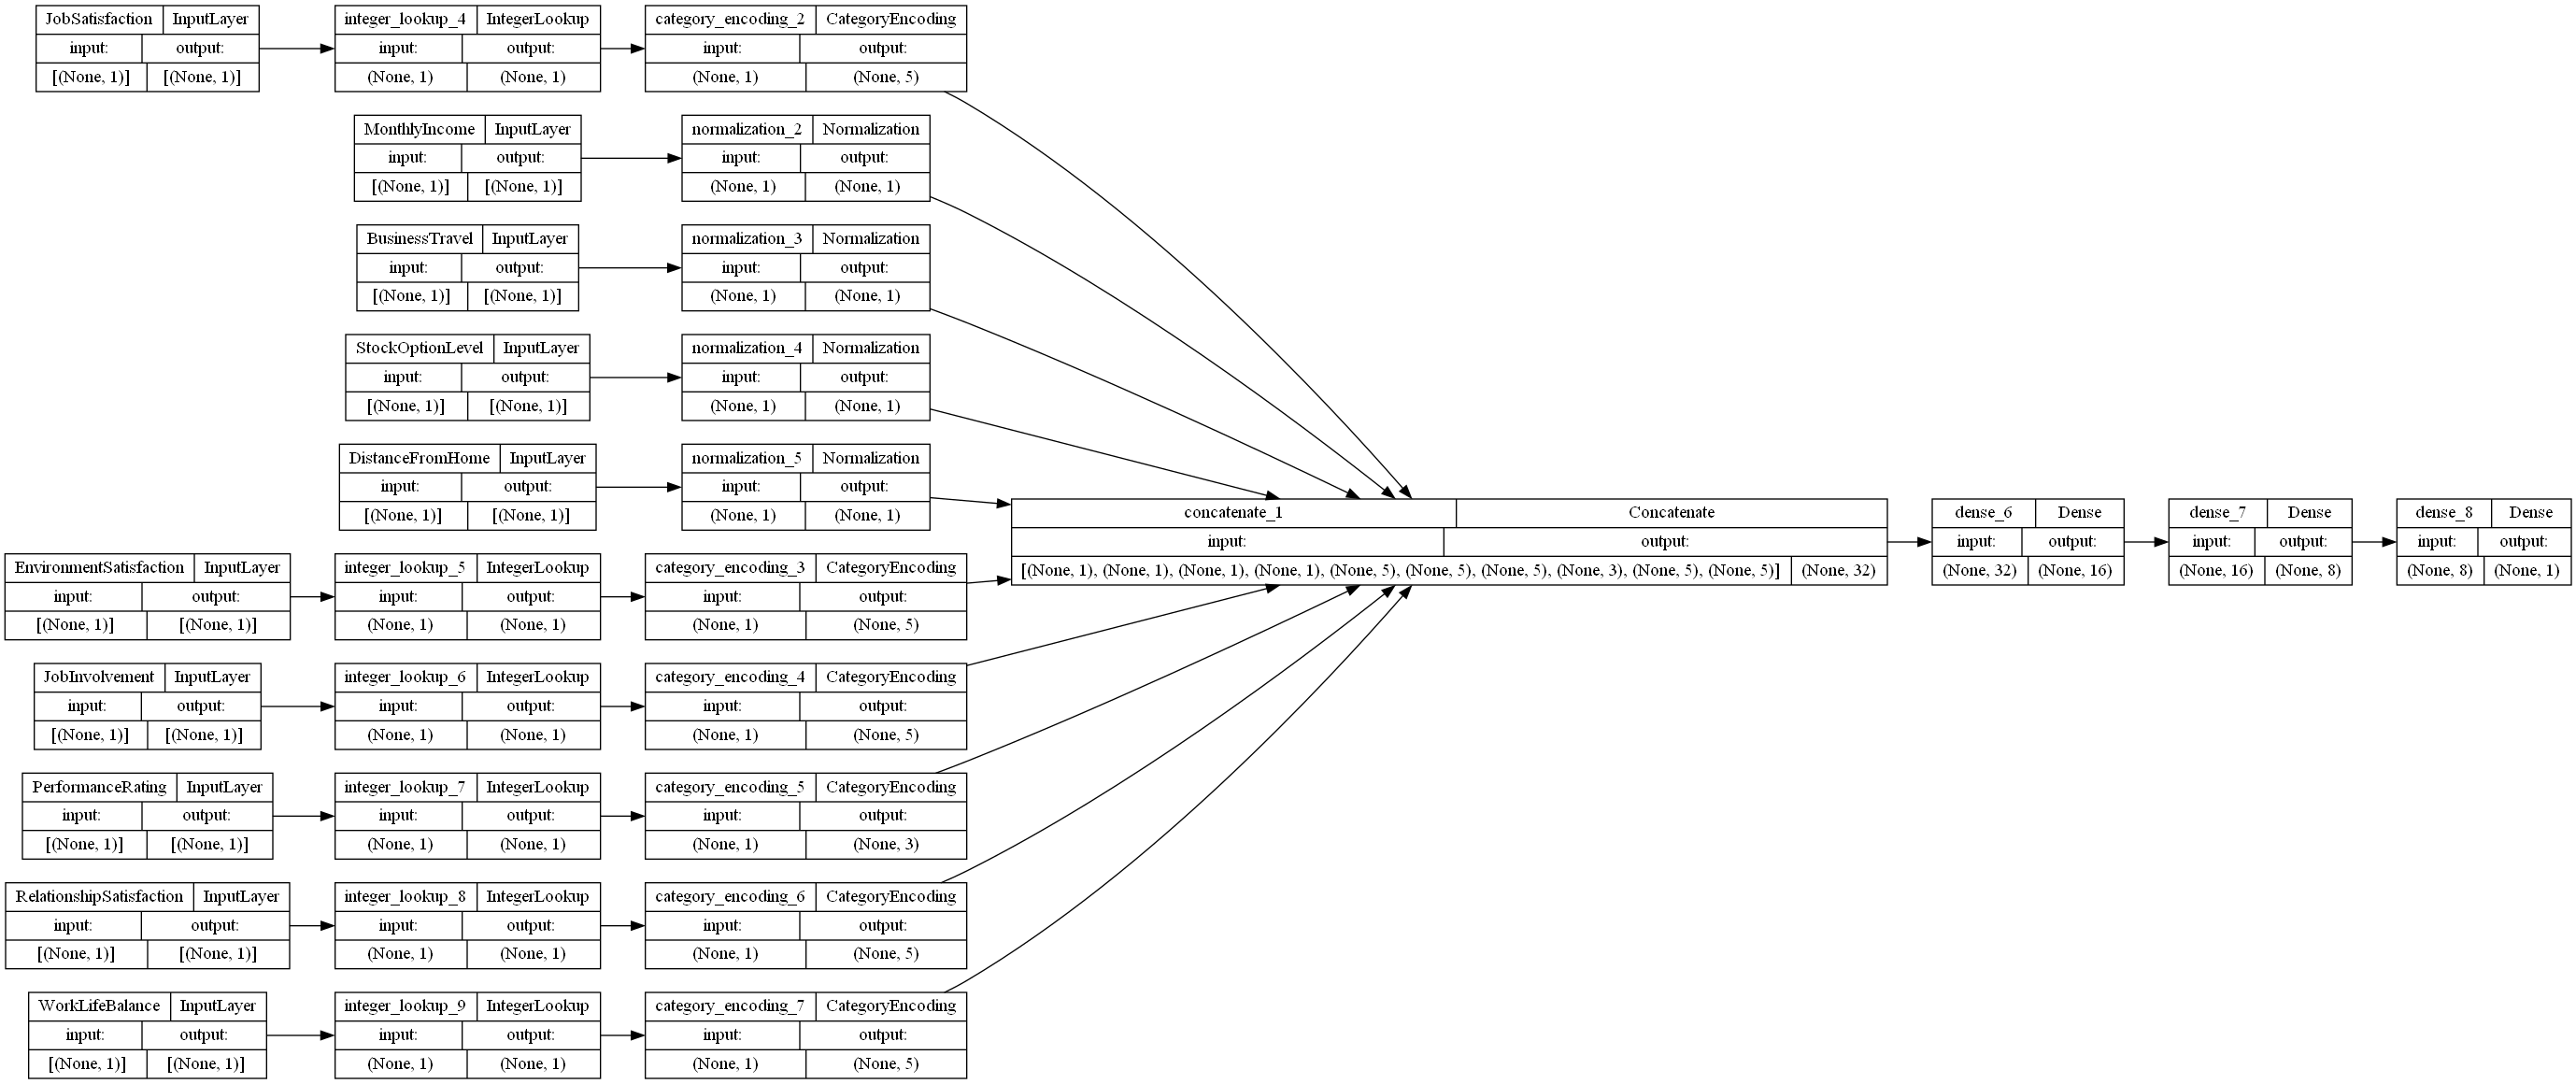

In [28]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [24]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\siman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\siman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\siman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\siman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\siman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\siman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 197, in assert_input_compatibility
        raise ValueError(

    ValueError: Missing data for input "input_1". You passed a data dictionary with keys ['Attrition', 'BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MaritalStatus', 'NumCompaniesWorked', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance', 'MonthlyIncome', 'DistanceFromHome']. Expected the following keys: ['input_1']


In [20]:
loss, accuracy, tp, tn, fp, fn = model.evaluate(test_ds)
print("Accuracy", accuracy)

f1 = 2*tp/(2*tp + fp + fn)
print("F1 score", f1)

1/1 [==============================] - 0s 24ms/step - loss: 1.0877 - accuracy: 0.7687 - true_positives: 8.0000 - true_negatives: 105.0000 - false_positives: 22.0000 - false_negatives: 12.0000
Accuracy 0.7687074542045593
F1 score 0.32


In [ ]:
model.save('attrition_classifier')